# Preparing data and a linear model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import talib as ta

In [2]:
!pip list

Package         Version
--------------- -------------------
certifi         2020.6.20
mkl-fft         1.2.0
mkl-random      1.1.1
mkl-service     2.3.0
numpy           1.19.1
pandas          1.1.2
pip             20.2.3
python-dateutil 2.8.1
pytz            2020.1
setuptools      49.6.0.post20200925
six             1.15.0
TA-Lib          0.4.19
wheel           0.35.1
wincertstore    0.2


In [3]:
!pip show TA-Lib

Name: TA-Lib
Version: 0.4.19
Summary: Python wrapper for TA-Lib
Home-page: http://github.com/mrjbq7/ta-lib
Author: John Benediktsson
Author-email: mrjbq7@gmail.com
License: BSD
Location: c:\users\ybant\anaconda3\envs\talib\lib\site-packages
Requires: numpy
Required-by: 


In [4]:
!python --version

Python 3.8.5


In [5]:
ta.__version__

'0.4.19'

## EDA

In [6]:
lng_df = pd.read_csv('data/LNG.csv', parse_dates=['Date'], index_col=0)
lng_df.head()

,Adj_Close,Adj_Volume
Date,,
1994-04-04,72.0,0.0
1994-04-05,108.0,0.0
1994-04-06,108.0,0.0
1994-04-07,108.0,0.0
1994-04-08,108.0,0.0


In [7]:
spy_df = pd.read_csv('data/SPY.csv', parse_dates=['Date'], index_col=0)
spy_df.head()

,Adj_Close,Adj_Volume
Date,,
1993-01-29,28.223927,1003200.0
1993-02-01,28.424666,480500.0
1993-02-02,28.484856,201300.0
1993-02-03,28.785997,529400.0
1993-02-04,28.906440,531500.0


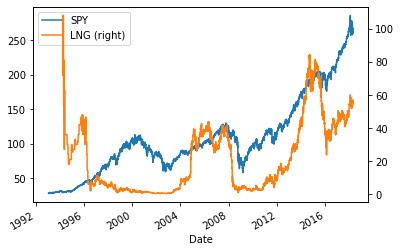

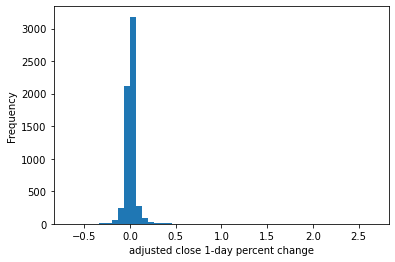

In [8]:
spy_df['Adj_Close'].plot(label='SPY', legend=True)
lng_df['Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()

lng_df['Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

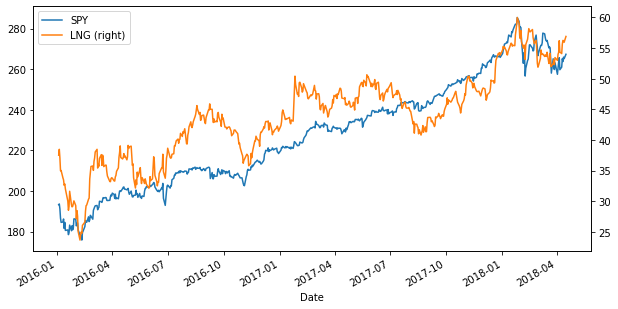

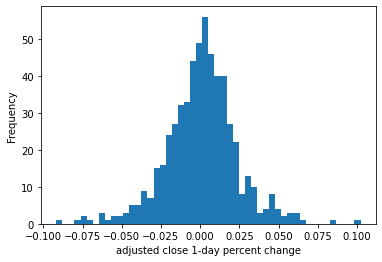

In [9]:
plt.figure(figsize=(10, 5))
spy_df.loc['2016':, 'Adj_Close'].plot(label='SPY', legend=True)
lng_df.loc['2016':, 'Adj_Close'].plot(label='LNG', legend=True, secondary_y=True)
plt.show()

plt.clf()

lng_df.loc['2016':, 'Adj_Close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

### Correlations

In [10]:
lng_df['5d_future_close'] = lng_df['Adj_Close'].shift(-5)
lng_df['5d_close_future_pct'] = lng_df['5d_future_close'].pct_change(5)
lng_df['5d_close_pct'] = lng_df['Adj_Close'].pct_change(5)

corr = lng_df[['5d_close_pct', '5d_close_future_pct']].corr()
print(corr)

                     5d_close_pct  5d_close_future_pct
5d_close_pct             1.000000            -0.034733
5d_close_future_pct     -0.034733             1.000000


## Data transforms, features, and targets
### Create moving average and RSI features

We want to add historical data to our machine learning models to make better predictions, but adding lots of historical time steps is tricky. Instead, we can condense information from previous points into a single timestep with indicators.

A moving average is one of the simplest indicators (it's the average of previous data points. This is the function `talib.SMA()` from the `TAlib` library.

Another common technical indicator is the **relative strength index (RSI)**. This is defined by:

$$ RSI = 100 - \frac{100}{1 + RS} $$

$$ RS = \frac{\text{average gain over } n \text{ periods}}{\text{average loss over } n \text{ periods}} $$

The $n$ periods is set in `talib.RSI()` as the `timeperiod` argument.

A common period for RSI is 14, so we'll use that as one setting in our calculations.

In [11]:
feature_names = ['5d_close_pct']  # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 200]:

    # Create the moving average indicator and divide by Adj_Close
    lng_df['ma' + str(n)] = ta.SMA(lng_df['Adj_Close'].values, timeperiod=n) / lng_df['Adj_Close']
    # Create the RSI indicator
    lng_df['rsi' + str(n)] = ta.RSI(lng_df['Adj_Close'].values, timeperiod=n)

    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

print(feature_names)

['5d_close_pct', 'ma14', 'rsi14', 'ma30', 'rsi30', 'ma50', 'rsi50', 'ma200', 'rsi200']


In [12]:
lng_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6052 entries, 1994-04-04 to 2018-04-16
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Adj_Close            6052 non-null   float64
 1   Adj_Volume           6052 non-null   float64
 2   5d_future_close      6047 non-null   float64
 3   5d_close_future_pct  6047 non-null   float64
 4   5d_close_pct         6047 non-null   float64
 5   ma14                 6039 non-null   float64
 6   rsi14                6038 non-null   float64
 7   ma30                 6023 non-null   float64
 8   rsi30                6022 non-null   float64
 9   ma50                 6003 non-null   float64
 10  rsi50                6002 non-null   float64
 11  ma200                5853 non-null   float64
 12  rsi200               5852 non-null   float64
dtypes: float64(13)
memory usage: 821.9 KB


In [13]:
lng_df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5847 entries, 1995-01-18 to 2018-04-09
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Adj_Close            5847 non-null   float64
 1   Adj_Volume           5847 non-null   float64
 2   5d_future_close      5847 non-null   float64
 3   5d_close_future_pct  5847 non-null   float64
 4   5d_close_pct         5847 non-null   float64
 5   ma14                 5847 non-null   float64
 6   rsi14                5847 non-null   float64
 7   ma30                 5847 non-null   float64
 8   rsi30                5847 non-null   float64
 9   ma50                 5847 non-null   float64
 10  rsi50                5847 non-null   float64
 11  ma200                5847 non-null   float64
 12  rsi200               5847 non-null   float64
dtypes: float64(13)
memory usage: 639.5 KB


In [14]:
lng_df = lng_df.dropna()

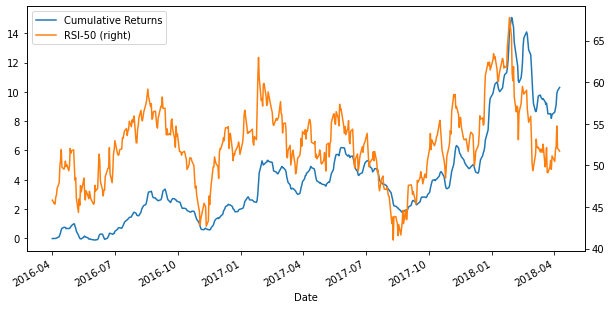

In [15]:
plt.figure(figsize=(10, 5))
lng_df.loc['2016-04':, '5d_close_pct'].add(1).cumprod().sub(1).plot(label='Cumulative Returns', legend=True)
lng_df.loc['2016-04':, 'rsi50'].plot(label='RSI-50', legend=True, secondary_y=True)
plt.show()

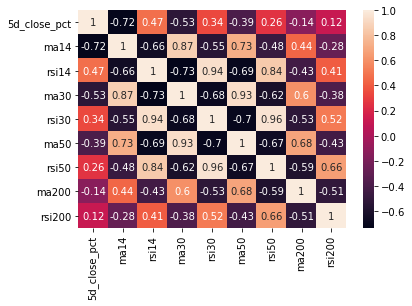

In [16]:
corr = lng_df[feature_names].corr()
sns.heatmap(corr, annot=True)
plt.show()

In [17]:
feat_targ_df = lng_df.drop(['5d_future_close', 'Adj_Volume', 'Adj_Close'], axis=1)
feat_targ_df = feat_targ_df.loc['2016-04':, :].copy()
feat_targ_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 509 entries, 2016-04-01 to 2018-04-09
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   5d_close_future_pct  509 non-null    float64
 1   5d_close_pct         509 non-null    float64
 2   ma14                 509 non-null    float64
 3   rsi14                509 non-null    float64
 4   ma30                 509 non-null    float64
 5   rsi30                509 non-null    float64
 6   ma50                 509 non-null    float64
 7   rsi50                509 non-null    float64
 8   ma200                509 non-null    float64
 9   rsi200               509 non-null    float64
dtypes: float64(10)
memory usage: 43.7 KB


## Linear Modeling

In [18]:
linear_features: np.ndarray = sm.add_constant(feat_targ_df.drop('5d_close_future_pct', axis=1).to_numpy())
linear_features.shape

(509, 10)

In [19]:
train_size: int = int(0.85 * linear_features.shape[0])

train_features = linear_features[:train_size]
train_targets = feat_targ_df['5d_close_future_pct'].to_numpy()[:train_size]

test_features = linear_features[train_size:]
test_targets = feat_targ_df['5d_close_future_pct'].to_numpy()[train_size:]

print(train_features.shape, train_targets.shape, test_features.shape, test_targets.shape)

(432, 10) (432,) (77, 10) (77,)


In [20]:
linreg = sm.OLS(train_targets, train_features)
results = linreg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     8.602
Date:                Sun, 11 Oct 2020   Prob (F-statistic):           7.18e-12
Time:                        17:12:08   Log-Likelihood:                 781.44
No. Observations:                 432   AIC:                            -1543.
Df Residuals:                     422   BIC:                            -1502.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1150      0.241      0.477      0.634      -0.359       0.589
x1            -0.2723      0.086     -3.176      0.002      -0.441      -0.104
x2             0.2764      0.182      1.516      0.130      -0.082       0.635
x3             0.0087      0.002      4.985      0.000       0.005       0.012
x4             0.5296      0.156      3.399      0.001       0.223       0.836
x5            -0.0281      0.008     -3.665      0.000      -0.043      -0.013
x6            -0.7003      0.138     -5.067      0.000      -0.972      -0.429
x7             0.0215      0.009      2.488      0.013       0.005       0.038
x8             0.0665      0.061      1.091      0.276      -0.053       0.186
x9            -0.0078      0.002     -3.142      0.002      -0.013      -0.003
==============================================================================
Omnibus:                       18.296   Durbin-Watson:                   0.466
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.831
Skew:                           0.237   Prob(JB):                     2.73e-08
Kurtosis:                       4.308   Cond. No.                     1.48e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
results.pvalues < 0.05

array([False,  True, False,  True,  True,  True,  True,  True, False,
        True])

A statistical test checking if the coefficients are significantly different from zero is the **p-value**. The p-value is the percent chance that the coefficient is actually zero. Generally, we say that a p-value of less than 0.05 means our coefficient is significantly different from zero. And in our case, it looks like a few of our coefficients are significant. This will improve later utilizing more sophisticated models and neural networks.

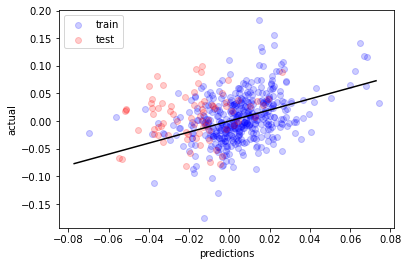

In [22]:
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()